In [ ]:
!pip install einops
!pip install gdown
# !pip install tensorflow-gpu
# Importing the libraries
import torch
from torch import nn, einsum
import torch.nn.functional as F

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import gdown

import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, trange
from torchvision import transforms

from torchvision import datasets, models, transforms

import os
from skimage import io

import torch
from PIL import Image

import glob

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

In [ ]:
# ------------------------------------------------------------------------------------------------------
# VIT MODEL
# ------------------------------------------------------------------------------------------------------

# helpers
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = self.attend(dots)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            # nn.Linear(dim, num_classes) # Output (batch_size, num_classes)
            nn.Linear(dim, 128) # 128 desired embedding size
            # nn.Linear(dim, 256)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

    def load_pretrained_weights(self, model_path):
        # Load the pre-trained weights from the specified model path
        state_dict = torch.load(model_path, map_location='cpu')

        # Filter and copy parameters
        filtered_state_dict = {}
        for name, param in state_dict.items():
            if name in self.state_dict():
                filtered_state_dict[name] = param

        # Resize position embedding
        if 'pos_embed' in filtered_state_dict:
            pos_embed = filtered_state_dict['pos_embed']
            print("Got pos_embed !")
            if pos_embed.shape != self.pos_embedding.shape:
                new_pos_embed = resize_pos_embedding(pos_embed, self.pos_embedding)
                filtered_state_dict['pos_embed'] = new_pos_embed
                print("Changed pos embeddings to : ", new_pow_embed)


        # Copy cls_token and attn parameters
        if 'cls_token' in filtered_state_dict:
            self.cls_token = filtered_state_dict['cls_token']
            print("Got a cls_token !")
        if 'attn' in filtered_state_dict:
            print("Got attn params !")
            for attn_type, attn_params in filtered_state_dict['attn'].items():
                for attn_name, attn_param in attn_params.items():
                    self.attn[attn_type][attn_name] = attn_param
        # Load the filtered state_dict into your model
        self.load_state_dict(filtered_state_dict, strict=False)


# -----------------------------------------------------------------------------------------------------------------------
# LOSS FUNCTION
# -----------------------------------------------------------------------------------------------------------------------
class RankingLoss:

  def __init__(self):
      pass

  def _label2similarity(sekf, label1, label2):
      '''
      compute similarity matrix of label1 and label2
      :param label1: torch.Tensor, [m]
      :param label2: torch.Tensor, [n]
      :return: torch.Tensor, [m, n], {0, 1}
      '''
      m, n = len(label1), len(label2)
      l1 = label1.view(m, 1).expand([m, n])
      l2 = label2.view(n, 1).expand([n, m]).t()
      similarity = l1 == l2
      return similarity

  def _batch_hard(self, mat_distance, mat_similarity, more_similar):

      if more_similar is 'smaller':
          sorted_mat_distance, _ = torch.sort(mat_distance + (-9999999.) * (1 - mat_similarity), dim=1, descending=True)
          hard_p = sorted_mat_distance[:, 0]
          sorted_mat_distance, _ = torch.sort(mat_distance + (9999999.) * (mat_similarity), dim=1, descending=False)
          hard_n = sorted_mat_distance[:, 0]
          return hard_p, hard_n

      elif more_similar is 'larger':
          sorted_mat_distance, _ = torch.sort(mat_distance + (9999999.) * (1 - mat_similarity), dim=1, descending=False)
          hard_p = sorted_mat_distance[:, 0]
          sorted_mat_distance, _ = torch.sort(mat_distance + (-9999999.) * (mat_similarity), dim=1, descending=True)
          hard_n = sorted_mat_distance[:, 0]
          return hard_p, hard_n


class TripletLoss(RankingLoss):
    '''
    Compute Triplet loss augmented with Batch Hard
    Details can be seen in 'In defense of the Triplet Loss for Person Re-Identification'
    Args:
        margin(float or 'soft'): if float, use nn.MarginRankingLoss, if 'soft',
    '''

    def __init__(self, margin, metric, reduce=True):
        '''
        :param margin: float or 'soft', for MarginRankingLoss with margin and soft margin
        :param bh: batch hard
        :param metric: l2 distance or cosine distance
        '''

        assert isinstance(margin, float) or margin=='soft', \
            'margin must be type float or value \'soft\', but got {}'.format(margin)
        if isinstance(margin, float):
            self.margin_loss = nn.MarginRankingLoss(margin=margin, reduce=reduce)
        elif margin == 'soft':
            self.margin_loss = nn.SoftMarginLoss(reduce=reduce)
        self.metric = metric

    def __call__(self, emb, label):
        '''
        :param emb: torch.Tensor, [m, dim]
        :param label: torch.Tensor, [b]
        '''

        if self.metric == 'cosine':
            mat_dist = cosine_dist(emb, emb)
            mat_sim = self._label2similarity(label, label)
            hard_p, _ = self._batch_hard(mat_dist, mat_sim.float(), more_similar='larger')

            mat_dist = cosine_dist(emb, emb)
            mat_sim = self._label2similarity(label, label)
            _, hard_n = self._batch_hard(mat_dist, mat_sim.float(), more_similar='larger')

            margin_label = -torch.ones_like(hard_p)

            # print(len(emb)) # batch-size
            # print(len(label))
            # print('Mat_dist : ', mat_dist)


        elif self.metric == 'euclidean':
            mat_dist = euclidean_dist(emb, emb)
            mat_sim = self._label2similarity(label, label)
            hard_p, _ = self._batch_hard(mat_dist, mat_sim.float(), more_similar='smaller')

            mat_dist = euclidean_dist(emb, emb)
            mat_sim = self._label2similarity(label, label)
            _, hard_n = self._batch_hard(mat_dist, mat_sim.float(), more_similar='smaller')

            margin_label = torch.ones_like(hard_p)

        if self.margin_loss.__class__.__name__ == 'MarginRankingLoss':
            return self.margin_loss(hard_n, hard_p, margin_label)
        elif self.margin_loss.__class__.__name__ == 'SoftMarginLoss':
            return self.margin_loss(hard_n-hard_p, margin_label)


def cosine_dist(x, y):
    '''
    compute cosine distance between two matrix x and y
    with size (n1, d) and (n2, d) and type torch.tensor
    return a matrix (n1, n2)
    '''

    x = F.normalize(x, p=2, dim=1)
    y = F.normalize(y, p=2, dim=1)
    return torch.matmul(x, y.transpose(0, 1))


def euclidean_dist(x, y):
    """
    compute euclidean distance between two matrix x and y
    with size (n1, d) and (n2, d) and type torch.tensor
    return a matrix (n1, n2)
    """
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(y, 2).sum(1, keepdim=True).expand(n, m).t()
    dist = xx + yy
    dist.addmm_(1, -2, x, y.t())
    dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
    return dist

# --------------------------------------------------------------------------------------------------------------------------------
# CUSTOMDATASET
# --------------------------------------------------------------------------------------------------------------------------------

class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='train'):
        self.root_dir = root_dir
        self.transform = transform
        self.split = split
        self.image_paths, self.labels = self._load_dataset()

    def _load_dataset(self):
        image_paths = []
        labels = []

        for person_id in os.listdir(os.path.join(self.root_dir, self.split)):
            person_folder = os.path.join(self.root_dir, self.split, person_id)

            if os.path.isdir(person_folder):
                for filename in os.listdir(person_folder):
                    if filename.endswith('.jpg'):
                        image_paths.append(os.path.join(person_folder, filename))
                        labels.append(int(person_id))

        return image_paths, labels

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = io.imread(img_path)
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label



# --------------------------------------------------------------------------------------------------------
# CENTER LOSS
# --------------------------------------------------------------------------------------------------------

class CenterLoss(nn.Module):
  """Center loss.

  Reference:
  Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.

  Args:
      num_classes (int): number of classes.
      feat_dim (int): feature dimension.
  """

  def __init__(self, num_classes=751, feat_dim=2048, use_gpu=True):
      super(CenterLoss, self).__init__()
      self.num_classes = num_classes
      self.feat_dim = feat_dim
      self.use_gpu = use_gpu

      if self.use_gpu:
          self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
      else:
          self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

  def forward(self, x, labels):
      """
      Args:
          x: feature matrix with shape (batch_size, feat_dim).
          labels: ground truth labels with shape (num_classes).
      """
      assert x.size(0) == labels.size(0), "features.size(0) is not equal to labels.size(0)"

      batch_size = x.size(0)
      distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
      # distmat = torch.addmm(distmat, x, self.centers.t(), beta=1, alpha=-2)
      distmat.addmm_(1, -2, x.float(), self.centers.t())

      classes = torch.arange(self.num_classes).long()
      if self.use_gpu: classes = classes.cuda()
      labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
      mask = labels.eq(classes.expand(batch_size, self.num_classes))

      dist = []
      for i in range(batch_size):
          value = distmat[i][mask[i]]
          value = value.clamp(min=1e-12, max=1e+12)  # for numerical stability
          dist.append(value)
      dist = torch.cat(dist)
      loss = dist.mean()
      return loss

# -----------------------------------------------------------------------------------------------
# CROSS ENTROPY LABEL SMOOTH
# -----------------------------------------------------------------------------------------------

class CrossEntropyLabelSmooth(nn.Module):
    """Cross entropy loss with label smoothing regularizer.

    Reference:
    Szegedy et al. Rethinking the Inception Architecture for Computer Vision. CVPR 2016.
    Equation: y = (1 - epsilon) * y + epsilon / K.

    Args:
        num_classes (int): number of classes.
        epsilon (float): weight.
    """

    def __init__(self, num_classes, epsilon=0.1, use_gpu=True):
        super(CrossEntropyLabelSmooth, self).__init__()
        self.num_classes = num_classes
        self.epsilon = epsilon
        self.use_gpu = use_gpu
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, inputs, targets):
        """
        Args:
            inputs: prediction matrix (before softmax) with shape (batch_size, num_classes)
            targets: ground truth labels with shape (num_classes)
        """
        log_probs = self.logsoftmax(inputs)
        targets = torch.zeros(log_probs.size()).scatter_(1, targets.unsqueeze(1).data.cpu(), 1)
        if self.use_gpu: targets = targets.cuda()
        targets = (1 - self.epsilon) * targets + self.epsilon / self.num_classes
        loss = (- targets * log_probs).mean(0).sum()
        return loss

class LabelSmoothingCrossEntropy(nn.Module):
    """
    NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.1):
        """
        Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothingCrossEntropy, self).__init__()
        assert smoothing < 1.0
        self.smoothing = smoothing
        self.confidence = 1. - smoothing

    def forward(self, x, target):
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

# ------------------------------------------------------------------------------------------------------------
# ONE LOSS FUNCTION TO RULE THEM ALL
# -------------------------------------------------------------------------------------------------------------

class TripletCenterLabelSmoothLoss():
    def __init__(self, margin=0.5, metric='cosine', smoothing=0.1, num_classes=1501, feat_dim=256, lambda_center=0.1, lambda_smooth=0.1):
        self.loss_triplet = TripletLoss(margin, metric)
        self.loss_center = CenterLoss(num_classes, feat_dim, use_gpu=True)
        self.loss_smooth = LabelSmoothingCrossEntropy(smoothing=smoothing)
        self.lambda_center = lambda_center
        self.lambda_smooth = lambda_smooth

    def __call__(self, outputs, labels):
        loss_triplet = self.loss_triplet(outputs, labels)
        loss_center = self.loss_center(outputs, labels)
        loss_smooth = self.loss_smooth(outputs, labels)

        loss = loss_triplet + self.lambda_center * loss_center + self.lambda_smooth * loss_smooth
        return loss

In [ ]:
def main():
    # Set your device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataset_root = '/content/drive/MyDrive/ViT/Data-Market/Market-1501-v15.09.15/pytorch/'

    # Create the dataset and dataloader
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 128)),
        transforms.ToTensor(),
    ])

    train_dataset = CustomDataset(root_dir=dataset_root, transform=transform, split='train')
    val_dataset = CustomDataset(root_dir=dataset_root, transform=transform, split='val')

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Define your vision transformer model
    model = ViT(
        image_size=(256, 128),
        patch_size=(16, 16),
        num_classes=1501,
        dim=768,
        depth=12,
        heads=8,
        mlp_dim=512,
        dropout=0.1,
        emb_dropout=0.1
    )

    model.load_pretrained_weights('/content/drive/MyDrive/ViT/Pretrained/jx_vit_base_p16_224-80ecf9dd.pth')

    model.to(device)

    # Define your optimizer and loss function
    optimizer = Adam(model.parameters(), lr=1e-4)
    loss_fn = TripletCenterLabelSmoothLoss(margin=0.5, metric='cosine', smoothing=0.1, num_classes=1501, feat_dim=256, lambda_center = 0.1, lambda_smooth = 0.1)

    # Training loop
    num_epochs = 20 # Set the number of epochs

    for epoch in range(num_epochs):
      # Training
      model.train()
      total_loss = 0.0
      num_batches = len(train_dataloader)
      for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} in training", leave=False):
          images, labels = batch
          images = images.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()
          outputs = model(images)

          print ('len outputs \n')
          print(len(outputs))

          loss = loss_fn(outputs, labels)

          print(loss)

          loss.backward()
          optimizer.step()
          # print("labels: ", len(labels))
          # print("Images: ", len(images))
          total_loss += loss.item()
      average_loss = total_loss / num_batches

      print(f'Training Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss}')
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

      # Validation
      model.eval()
      total_val_loss = 0.0
      num_val_batches = len(val_dataloader)

      with torch.no_grad():
          for val_batch in tqdm(val_dataloader, desc=f"Epoch {epoch + 1} in validation", leave=False):
              val_images, val_labels = val_batch
              val_images = val_images.to(device)
              val_labels = val_labels.to(device)
              val_outputs = model(val_images)
              val_loss = loss_fn(val_outputs, val_labels)
              total_val_loss += val_loss.item()

      average_val_loss = total_val_loss / num_val_batches
      print(f'Validation Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_val_loss}')

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/ViT/Model/model_v2.pth')


In [ ]:
def main():

    transform = transforms.Compose([
        # transforms.ToPILImage(),
        transforms.ToTensor(),
    ])

    # Load data
    train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
    test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=64)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=64)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    model = ViT(image_size=(28, 28), patch_size=(7, 7), num_classes=10, dim=8, depth=2, heads=2, mlp_dim=8, pool='cls', channels=1, dim_head=64, dropout=0.1, emb_dropout=0.1).to(device)

    # USE A PRETRAINED MODEL
    # Maybe SWIN ?
    # model.load_pretrained_weights('/content/drive/MyDrive/ViT/Pretrained/jx_vit_base_p16_224-80ecf9dd.pth')

    if torch.cuda.is_available():
      model.to('cuda')


   # Define your optimizer and loss function
    optimizer = Adam(model.parameters(), lr=1e-4)
    loss_fn = TripletCenterLabelSmoothLoss(margin=0.5, metric='cosine', smoothing=0.1, num_classes=10, feat_dim=128, lambda_center=0.1, lambda_smooth=0.2)

    # Training loop
    num_epochs = 10  # Set the number of epochs

    for epoch in range(num_epochs):
      # Training
      model.train()
      total_loss = 0.0
      num_batches = len(train_loader)
      print(num_batches)
      for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
          images, labels = batch
          if torch.cuda.is_available():
            images = images.to('cuda')
            labels = labels.to('cuda')
          optimizer.zero_grad()
          outputs = model(images)
          # print('outputs')
          # print(outputs)
          # print(len(outputs))
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
      average_loss = total_loss / num_batches

      print(f'Training Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss}')
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

      # Validation
      model.eval()
      total_val_loss = 0.0
      num_val_batches = len(test_loader)

      with torch.no_grad():
          for val_batch in tqdm(test_loader, desc=f"Epoch {epoch + 1} in validation", leave=False):
              val_images, val_labels = val_batch
              if torch.cuda.is_available():
                val_images = images.to('cuda')
                val_labels = labels.to('cuda')
              val_outputs = model(val_images)
              val_loss = loss_fn(val_outputs, val_labels)
              total_val_loss += val_loss.item()

      average_val_loss = total_val_loss / num_val_batches
      print(f'Validation Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_val_loss}')

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/ViT/Model/model_MNIST_v4.pth')


In [ ]:
if __name__ == "__main__":
    main()

Using device:  cuda (Tesla V100-SXM2-16GB)


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Got a cls_token !
938


Training Epoch [1/40], Average Loss: 14.126059070579025
Epoch [1/40], Loss: 12.79531478881836


Validation Epoch [1/40], Average Loss: 12.539384841918945
938


Training Epoch [2/40], Average Loss: 12.233412285095085
Epoch [2/40], Loss: 12.703386306762695


Validation Epoch [2/40], Average Loss: 12.47451400756836
938


Training Epoch [3/40], Average Loss: 11.863102267291755
Epoch [3/40], Loss: 11.884346008300781


Validation Epoch [3/40], Average Loss: 11.755167007446289
938


Training Epoch [4/40], Average Loss: 11.577548683833466
Epoch [4/40], Loss: 11.492294311523438


Validation Epoch [4/40], Average Loss: 11.241252899169922
938


Training Epoch [5/40], Average Loss: 11.065673293335351
Epoch [5/40], Loss: 10.38178825378418


Validation Epoch [5/40], Average Loss: 10.135956764221191
938


Training Epoch [6/40], Average Loss: 10.59064755612599
Epoch [6/40], Loss: 9.746455192565918


Validation Epoch [6/40], Average Loss: 9.11161994934082
938


Training Epoch [7/40], Average Loss: 10.282251776916894
Epoch [7/40], Loss: 10.595149993896484


Validation Epoch [7/40], Average Loss: 10.13658332824707
938


Training Epoch [8/40], Average Loss: 10.035997027781471
Epoch [8/40], Loss: 9.19818115234375


Validation Epoch [8/40], Average Loss: 8.604930877685547
938


Training Epoch [9/40], Average Loss: 9.81775647999127
Epoch [9/40], Loss: 9.023728370666504


Validation Epoch [9/40], Average Loss: 8.628971099853516
938


Training Epoch [10/40], Average Loss: 9.64691252698268
Epoch [10/40], Loss: 7.793623924255371


Validation Epoch [10/40], Average Loss: 7.041539192199707
938


Training Epoch [11/40], Average Loss: 9.479213275889089
Epoch [11/40], Loss: 9.410972595214844


Validation Epoch [11/40], Average Loss: 8.786444664001465
938


Training Epoch [12/40], Average Loss: 9.29727762492735
Epoch [12/40], Loss: 9.764382362365723


Validation Epoch [12/40], Average Loss: 8.94824504852295
938


Training Epoch [13/40], Average Loss: 9.128496130392241
Epoch [13/40], Loss: 9.177515983581543


Validation Epoch [13/40], Average Loss: 8.318849563598633
938


Training Epoch [14/40], Average Loss: 8.959551720222684
Epoch [14/40], Loss: 9.222790718078613


Validation Epoch [14/40], Average Loss: 8.554915428161621
938


Training Epoch [15/40], Average Loss: 8.836248762826168
Epoch [15/40], Loss: 7.959005355834961


Validation Epoch [15/40], Average Loss: 7.087557792663574
938


Training Epoch [16/40], Average Loss: 8.726792404138203
Epoch [16/40], Loss: 8.027365684509277


Validation Epoch [16/40], Average Loss: 7.171017646789551
938


Training Epoch [17/40], Average Loss: 8.656676590823924
Epoch [17/40], Loss: 8.500289916992188


Validation Epoch [17/40], Average Loss: 7.57161283493042
938


Training Epoch [18/40], Average Loss: 8.576578865681629
Epoch [18/40], Loss: 8.232394218444824


Validation Epoch [18/40], Average Loss: 7.147830486297607
938


Training Epoch [19/40], Average Loss: 8.489355135574016
Epoch [19/40], Loss: 8.168453216552734


Validation Epoch [19/40], Average Loss: 7.458547592163086
938


Training Epoch [20/40], Average Loss: 8.390504517789081
Epoch [20/40], Loss: 6.586114406585693


Validation Epoch [20/40], Average Loss: 5.551845073699951
938


Training Epoch [21/40], Average Loss: 8.301214626857213
Epoch [21/40], Loss: 9.500414848327637


Validation Epoch [21/40], Average Loss: 7.6943254470825195
938


Training Epoch [22/40], Average Loss: 8.207387932328018
Epoch [22/40], Loss: 8.61316204071045


Validation Epoch [22/40], Average Loss: 6.722458839416504
938


KeyboardInterrupt: ignored

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from torchvision.datasets import MNIST
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import Axes3D for 3D plotting

# Load your test set
transform = transforms.Compose([
    transforms.ToTensor(),
])

test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, shuffle=False, batch_size=64)

# Define your model and load the trained weights
model = ViT(image_size=(28, 28), patch_size=(7, 7), num_classes=10, dim=8, depth=2, heads=2, mlp_dim=8,
            pool='cls', channels=1, dim_head=64, dropout=0.1, emb_dropout=0.1)
model.load_state_dict(torch.load('/content/drive/MyDrive/ViT/Model/model_MNIST_v3_epoch40.pth'))
model.eval()

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Get embeddings for the entire test set
embeddings = []
labels = []

with torch.no_grad():
    for batch in test_loader:
        images, batch_labels = batch
        images = images.to(device)
        batch_labels = batch_labels.to(device)

        # Get model outputs
        outputs = model(images)
        embeddings.append(outputs.cpu().numpy())
        labels.append(batch_labels.cpu().numpy())

# Concatenate embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

# Apply t-SNE for visualization in 3D
tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)

# Visualize the t-SNE embeddings in 3D
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=labels, cmap='viridis')

ax.set_title("t-SNE Visualization in 3D on Test Set")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
fig.colorbar(scatter)
plt.show()

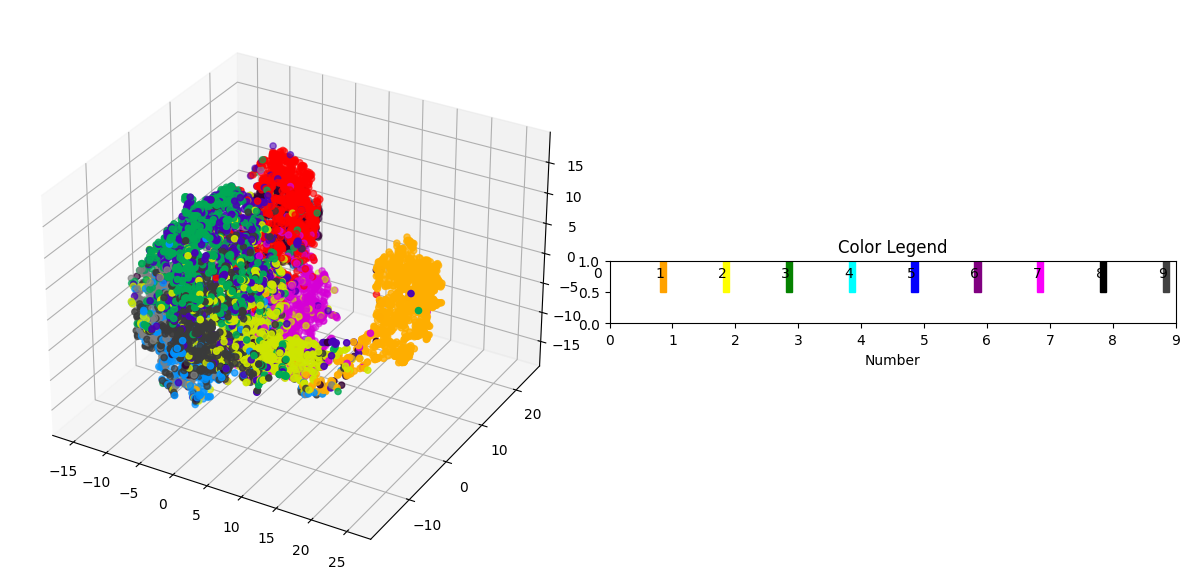

In [ ]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Define a custom colormap that maps each number to a unique color
cmap = LinearSegmentedColormap.from_list('custom_cmap', [
    (0.0, 'red'),
    (0.1, 'orange'),
    (0.2, 'yellow'),
    (0.3, 'green'),
    (0.4, 'cyan'),
    (0.5, 'blue'),
    (0.6, 'purple'),
    (0.7, 'magenta'),
    (0.8, 'black'),
    (1.0, 'gray'),
])

# ...

# Visualize the t-SNE embeddings in 3D
fig = plt.figure(figsize=(12, 10))

ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=labels, cmap=cmap)

# Create a sidebar Axes object
ax2 = fig.add_subplot(122, aspect='equal')

# Create rectangles for each number
for i in range(10):
    rectangle = patches.Rectangle((i - 0.2, 0.5), 0.1, 0.7, color=cmap(i / 10))
    ax2.add_patch(rectangle)

# Add labels to the rectangles
for i in range(10):
    label = ax2.text(i - 0.2, 0.8, str(i), color='black', ha='center', va='center')

ax2.set_xlabel('Number')
ax2.set_ylabel('')
ax2.set_title('Color Legend')
ax2.set_xticks(range(10))

# Add a tight_layout to ensure that both axes are displayed correctly
plt.tight_layout()

# Show the plot
plt.show()